In [1]:
from astropy.io import fits
from astropy import units, constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
from voigt_fit_lib import *
import os
import pickle

In [2]:
# Dictionary of colors for various ions
color_dict={'CIII':'maroon', 'CIV':'red',
            'SiIII':'gray',
            'OIII':'navy', 'OIV':'dodgerblue', 'OV':'lightskyblue', 'OVI':'cyan',
            'SVI':'coral',
            'NIV':'green',
            'NeV':'purple', 'NeVI':'violet'}

In [3]:
def plot_point(ax, x, x_lo, x_hi, y, y_lo, y_hi, l, c):
    
        # Default parameters, assuming both have detections
        fc = c
        
        # First, check for a non-detection
        detection_x = True
        detection_y = True        
        
        if np.isnan(x):
            detection_x = False
 
        if np.isnan(y):
            detection_y = False
            
        # If non-detection, check if upper limit or lower limit
        if not detection_x:
            
            fc = 'none'
            
            # For upper limit
            if np.isnan(x_lo): 
                x = x_hi
            
            # For lower limit
            else:
                x = x_lo
        
        # Do the same thing for y
        if not detection_y:   
            
            fc = 'none'

            # For upper limit
            if np.isnan(y_lo):
                y = y_hi
            
            # For lower limit
            else:
                y = y_lo  
        
        # If there's a detection in x, draw horizontal error bars
        if detection_x:
            ax.errorbar(x, y, fmt='none', xerr=[[x-x_lo],[x_hi-x]], solid_capstyle='projecting', capsize=5, color=c)
    
        # If non-detection, draw arrow based on upper or lower limit
        else:
            if x==x_hi:
                ax.quiver(x, y, -.3, 0, units='inches', angles='xy', scale=1,
                          scale_units='inches', color=c)  
              
            else:
                ax.quiver(x, y, .3, 0, units='inches', angles='xy', scale=1,
                          scale_units='inches', color=c)
        
        # If there's a detection in x, draw horizontal error bars
        if detection_y:
            ax.errorbar(x, y, fmt='none', yerr=[[y-y_lo],[y_hi-y]], solid_capstyle='projecting', capsize=5, color=c)
        # If non-detection, draw array based on upper or lower limit
        else:
            if y==y_hi:
                ax.quiver(x, y, 0, -.3, units='inches', angles='xy', scale=1,
                          scale_units='inches', color=c)
            else:
                ax.quiver(x, y, 0, .3, units='inches', angles='xy', scale=1,
                          scale_units='inches', color=c)

        # Create the scatter point - this will be open if we have a non-detection
        ax.scatter(x, y, label=l, facecolors=fc, color=c)

In [4]:
def make_comparison_plots(axes, df):
    
    
    # Compare column densities
    for i in range(len(df)):
        
        # Default parameters, assuming both have detections
        
        l = df.loc[i,'Line']
        
        x = df.loc[i,'logN_mid_sk']
        x_lo = df.loc[i,'logN_lo_sk']
        x_hi = df.loc[i,'logN_hi_sk']
        
        y = df.loc[i,'logN_mid_ss']
        y_lo = df.loc[i,'logN_lo_ss']
        y_hi = df.loc[i,'logN_hi_ss']
        
        c = color_dict[l]
        
        plot_point(axes[0], x, x_lo, x_hi, y, y_lo, y_hi, l, c)

                
    # Draw y=x
    lims_logN = [
        np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
        np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
    ]

    axes[0].set_xlabel(r'$\log(N)$ (Kumar)')
    axes[0].set_ylabel(r'$\log(N)$ (Sankar)')

    axes[0].plot(lims_logN, lims_logN, 'gray', lw=1, linestyle=':')
    
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Compare b values

    for i in range(len(df)):
        
        # Default parameters, assuming both have detections
        
        l = df.loc[i,'Line']
        
        x = df.loc[i,'b_mid_sk']
        x_lo = df.loc[i,'b_lo_sk']
        x_hi = df.loc[i,'b_hi_sk']
        
        y = df.loc[i,'b_mid_ss']
        y_lo = df.loc[i,'b_lo_ss']
        y_hi = df.loc[i,'b_hi_ss']
        
        c = color_dict[l]
                
        plot_point(axes[1], x, x_lo, x_hi, y, y_lo, y_hi, l, c)

    # Draw y=x
    lims_b = [
        np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
        np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
    ]

    axes[1].plot(lims_b, lims_b, 'gray', lw=1, linestyle=':')

    axes[1].set_xlabel(r'$b$ (Kumar)')
    axes[1].set_ylabel(r'$b$ (Sankar)')
    
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
def make_phase_plot(ax, df, author, title):
   
    # Compare column densities
    for i in range(len(df)):
        
        # Default parameters, assuming both have detections
        
        l = df.loc[i,'Line']
        
        x = df.loc[i,'b_mid_{}'.format(author)]
        x_lo = df.loc[i,'b_lo_{}'.format(author)]
        x_hi = df.loc[i,'b_hi_{}'.format(author)]
        
        y = df.loc[i,'logN_mid_{}'.format(author)]
        y_lo = df.loc[i,'logN_lo_{}'.format(author)]
        y_hi = df.loc[i,'logN_hi_{}'.format(author)]

        c = color_dict[l]
        
        plot_point(ax, x, x_lo, x_hi, y, y_lo, y_hi, l, c)

    ax.set_title(title)
    ax.set_xlabel(r'$b$')
    ax.set_ylabel(r'$\log(N)$')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [6]:
def axes_dyn_range(axes, df, x_tol=2, y_tol=0.1, x_scale=True, y_scale=True):
    
    if x_scale == True:
        axes[0].set_xlim(np.nanmin(np.concatenate((df.loc[:,'b_lo_sk'], df.loc[:,'b_lo_ss'])))-x_tol, np.nanmax(np.concatenate((df.loc[:,'b_hi_sk'], df.loc[:,'b_hi_ss'])))+x_tol)
        axes[1].set_xlim(np.nanmin(np.concatenate((df.loc[:,'b_lo_sk'], df.loc[:,'b_lo_ss'])))-x_tol, np.nanmax(np.concatenate((df.loc[:,'b_hi_sk'], df.loc[:,'b_hi_ss'])))+x_tol)

    if y_scale == True:
        axes[0].set_ylim(np.nanmin(np.concatenate((df.loc[:,'logN_lo_sk'], df.loc[:,'logN_lo_ss'])))-y_tol, np.nanmax(np.concatenate((df.loc[:,'logN_hi_sk'], df.loc[:,'logN_hi_ss'])))+y_tol)
        axes[1].set_ylim(np.nanmin(np.concatenate((df.loc[:,'logN_lo_sk'], df.loc[:,'logN_lo_ss'])))-y_tol, np.nanmax(np.concatenate((df.loc[:,'logN_hi_sk'], df.loc[:,'logN_hi_ss'])))+y_tol)

# Load
Load all files

In [7]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

In [8]:
df1_sk = pd.read_csv(rootdir+'z=0.6756_kumar.csv')
df1_ss = pd.read_csv(rootdir+'z=0.6756_sankar.csv')

df2_sk = pd.read_csv(rootdir+'z=0.7268_kumar.csv')
df2_ss = pd.read_csv(rootdir+'z=0.7268_sankar.csv')

df3_sk = pd.read_csv(rootdir+'z=1.0946_kumar.csv')
df3_ss = pd.read_csv(rootdir+'z=1.0946_sankar.csv')

df4_sk = pd.read_csv(rootdir+'z=1.1659_kumar.csv')
df4_ss = pd.read_csv(rootdir+'z=1.1659_sankar.csv')

df5_sk = pd.read_csv(rootdir+'z=1.2777_kumar.csv')
df5_ss = pd.read_csv(rootdir+'z=1.2777_sankar.csv')

In [9]:
df1 = pd.merge(df1_sk, df1_ss, on='Line', how='left')
df2 = pd.merge(df2_sk, df2_ss, on='Line', how='left')
df3 = pd.merge(df3_sk, df3_ss, on='Line', how='left')
df4 = pd.merge(df4_sk, df4_ss, on='Line', how='left')
df5 = pd.merge(df5_sk, df5_ss, on='Line', how='left')

# z=0.6756 absorber

In [10]:
df1

,Line,logN_lo_sk,logN_mid_sk,logN_hi_sk,b_lo_sk,b_mid_sk,b_hi_sk,v_lo_sk,v_mid_sk,v_hi_sk,...,W_r_hi_ss,logN_lo_ss,logN_mid_ss,logN_hi_ss,b_lo_ss,b_mid_ss,b_hi_ss,v_lo_ss,v_mid_ss,v_hi_ss
0,CIII,13.932185,13.973532,14.027113,28.784793,30.854768,32.897918,0.786763,1.989262,3.213719,...,NaN,13.80,13.90,14.00,27.0,33.0,39.0,-14.0,-10.0,-6.0
1,CIV,13.649429,13.728394,13.808021,27.571378,35.751709,46.412839,-1.645083,2.976849,9.009332,...,NaN,13.58,13.83,14.08,25.0,33.0,41.0,-30.0,-12.0,6.0
2,OIII,14.424105,14.440720,14.457085,33.224818,34.890658,36.653297,-0.808184,0.387317,1.588737,...,NaN,14.36,14.43,14.50,30.0,36.0,42.0,-21.0,-15.0,-9.0
3,OIV,14.948752,14.998013,15.065837,27.355054,29.194988,30.898465,0.113811,1.095071,2.074787,...,NaN,14.81,14.97,15.13,25.0,33.0,41.0,-4.0,1.0,6.0
4,OVI,14.277780,14.307133,14.336287,30.711964,33.372933,36.173642,-5.553057,-3.524487,-1.521965,...,NaN,14.21,14.31,14.41,28.0,39.0,50.0,-7.0,1.0,9.0


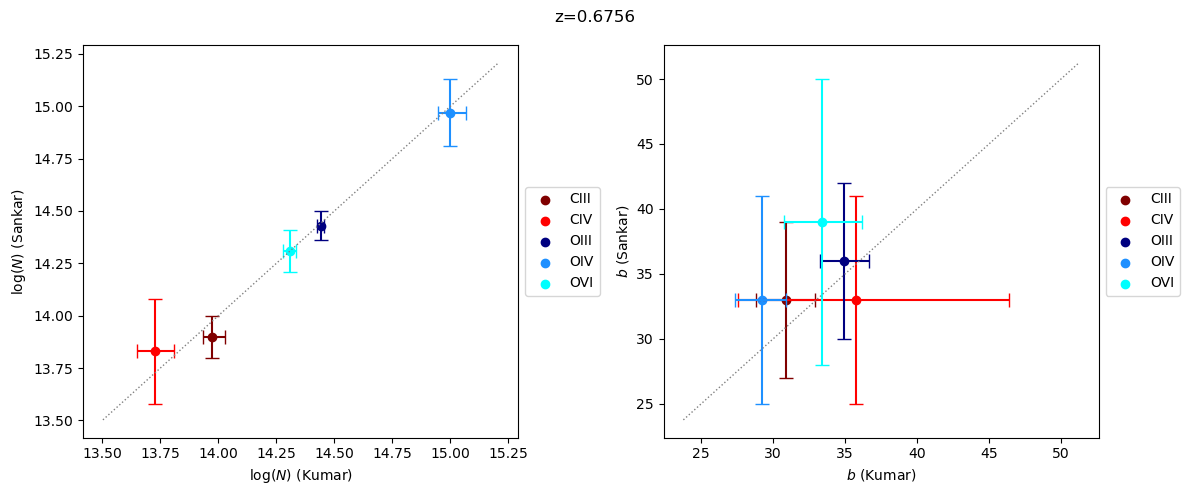

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_comparison_plots(axes, df1)

fig.suptitle('z=0.6756')
plt.tight_layout()

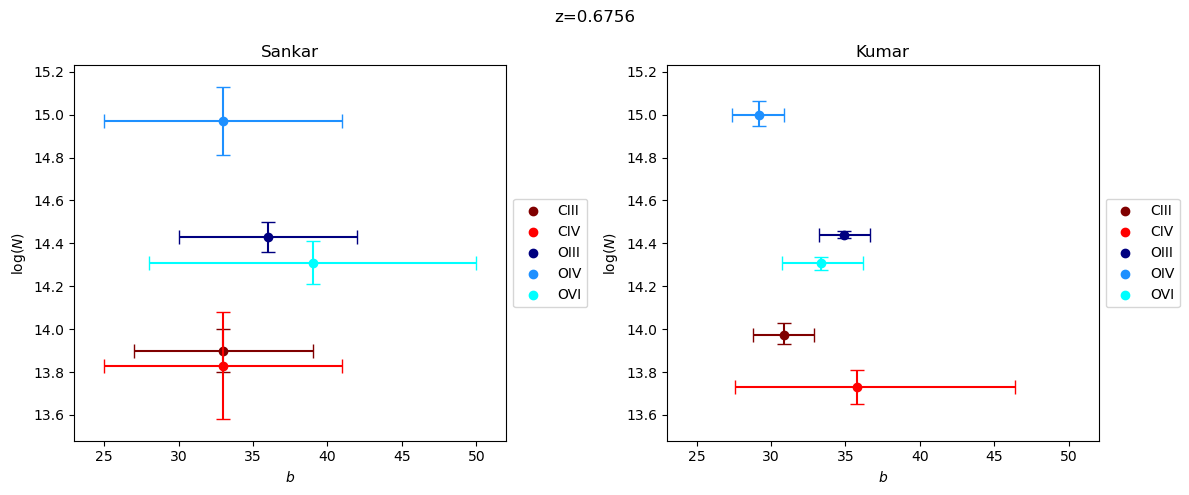

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_phase_plot(axes[0], df1, 'ss', 'Sankar')
make_phase_plot(axes[1], df1, 'sk', 'Kumar')

axes_dyn_range(axes, df1)

fig.suptitle('z=0.6756')
plt.tight_layout()

# z=0.7288 abosrber

In [45]:
df2

,Line,logN_lo_sk,logN_mid_sk,logN_hi_sk,b_lo_sk,b_mid_sk,b_hi_sk,v_lo_sk,v_mid_sk,v_hi_sk,...,W_r_hi_ss,logN_lo_ss,logN_mid_ss,logN_hi_ss,b_lo_ss,b_mid_ss,b_hi_ss,v_lo_ss,v_mid_ss,v_hi_ss
0,CIII,13.371068,13.422866,13.482367,14.042023,17.073734,20.677429,-2.815709,-1.095637,0.640774,...,NaN,13.29,13.34,13.39,14.0,17.0,20.0,-1.0,1.0,3.0
1,OIII,13.916867,13.952836,13.989186,10.034104,11.791496,13.574158,-1.952090,-0.875842,0.218259,...,NaN,14.04,14.10,14.16,15.0,19.0,23.0,0.0,2.0,4.0
2,OIV,14.566966,14.601523,14.642096,17.549799,18.775734,20.018938,-2.233905,-1.423768,-0.632356,...,NaN,14.31,14.43,14.55,18.0,22.0,26.0,-3.0,1.0,5.0
3,OVI,14.085061,14.149926,14.210153,55.818459,66.629227,79.999885,-13.887570,-5.697558,2.526853,...,NaN,13.93,14.00,14.07,50.0,61.0,72.0,-29.0,-21.0,-13.0


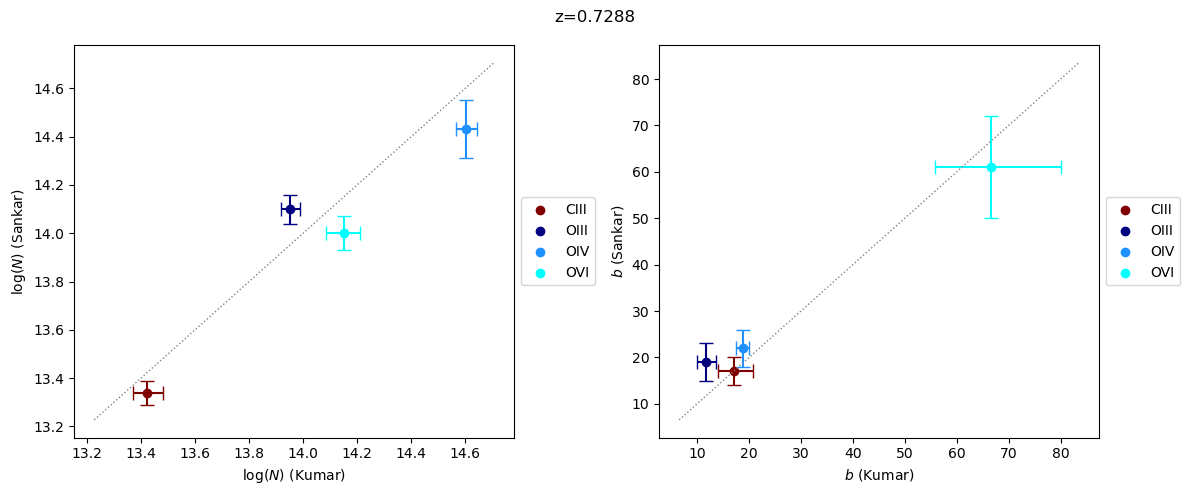

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_comparison_plots(axes, df2)

fig.suptitle('z=0.7288')
plt.tight_layout()

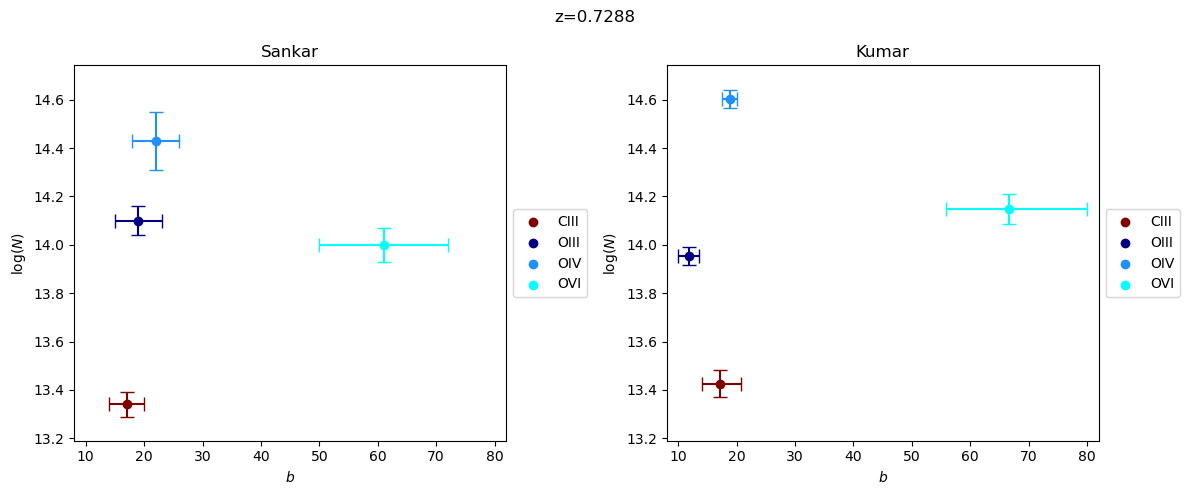

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_phase_plot(axes[0], df2, 'ss', 'Sankar')
make_phase_plot(axes[1], df2, 'sk', 'Kumar')

axes_dyn_range(axes, df2)

fig.suptitle('z=0.7288')
plt.tight_layout()

# z=1.0946 absorber

In [48]:
df3

,Line,logN_lo_sk,logN_mid_sk,logN_hi_sk,b_lo_sk,b_mid_sk,b_hi_sk,v_lo_sk,v_mid_sk,v_hi_sk,...,W_r_hi_ss,logN_lo_ss,logN_mid_ss,logN_hi_ss,b_lo_ss,b_mid_ss,b_hi_ss,v_lo_ss,v_mid_ss,v_hi_ss
0,NIV,12.890653,13.011473,13.114721,8.263337,13.171067,19.850799,0.132704,3.931149,7.630052,...,NaN,12.60,12.96,13.32,15.0,17.0,19.0,1.0,4.0,7.0
1,OIII,14.256139,14.277560,14.298550,22.889145,24.412820,26.019989,-0.843681,0.286876,1.411766,...,NaN,14.17,14.23,14.29,15.0,18.0,21.0,4.0,6.0,8.0
2,OIV,14.647591,14.665156,14.683181,21.736203,22.690189,23.664587,-1.539218,-0.843569,-0.157991,...,NaN,14.64,14.69,14.74,15.0,18.0,21.0,-1.0,1.0,3.0
3,OV,14.154915,14.189206,14.231158,23.722887,25.389482,27.079852,0.622624,1.664761,2.707879,...,NaN,14.45,14.63,14.81,16.0,18.0,20.0,-2.0,0.0,2.0
4,OVI,13.764530,13.885284,13.986063,23.915489,32.203763,44.935664,-4.828274,1.883680,9.233483,...,NaN,13.86,14.03,14.20,14.0,18.0,22.0,4.0,12.0,20.0


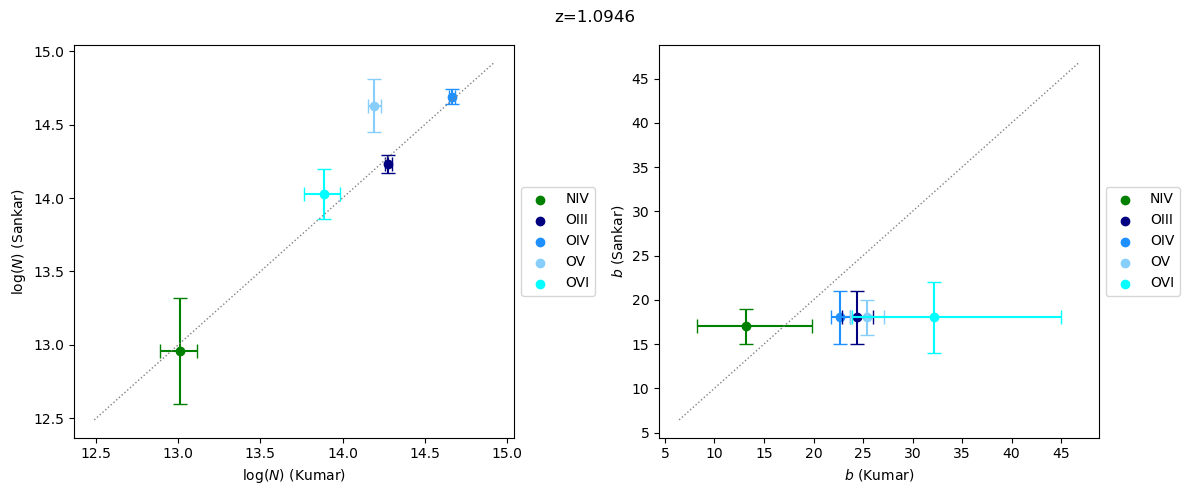

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_comparison_plots(axes, df3)

fig.suptitle('z=1.0946')
plt.tight_layout()

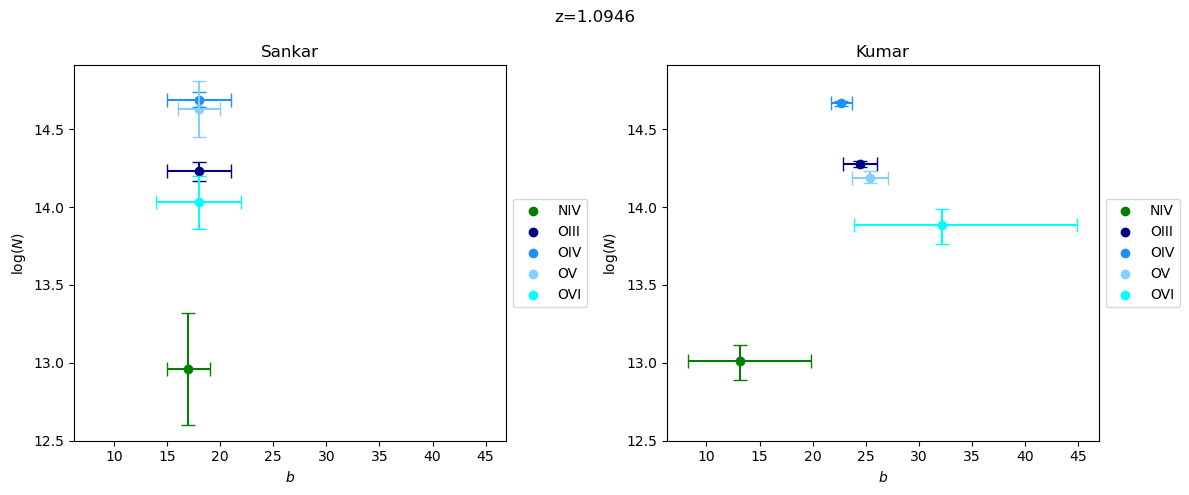

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_phase_plot(axes[0], df3, 'ss', 'Sankar')
make_phase_plot(axes[1], df3, 'sk', 'Kumar')

axes_dyn_range(axes, df3)

fig.suptitle('z=1.0946')
plt.tight_layout()

# z=1.1659 absorber

In [51]:
df4

,Line,logN_lo_sk,logN_mid_sk,logN_hi_sk,b_lo_sk,b_mid_sk,b_hi_sk,v_lo_sk,v_mid_sk,v_hi_sk,...,W_r_hi_ss,logN_lo_ss,logN_mid_ss,logN_hi_ss,b_lo_ss,b_mid_ss,b_hi_ss,v_lo_ss,v_mid_ss,v_hi_ss
0,CIII,13.413782,13.632327,14.304254,7.483016,12.494095,22.816208,-5.093998,-1.121370,2.290071,...,NaN,13.11,13.81,14.51,12.0,14.0,16.0,-2.0,9.0,20.0
1,OIII,14.153516,14.200731,14.249160,14.488190,17.246892,20.358347,-2.707840,-0.933086,0.771464,...,NaN,14.04,14.18,14.32,10.0,12.0,14.0,3.0,6.0,9.0
2,OIV,14.182764,14.256855,14.324295,12.129357,14.534057,17.214988,-3.650000,-3.650000,-3.650000,...,NaN,14.24,14.36,14.48,9.0,10.0,11.0,7.0,9.0,11.0
3,OIV,14.182764,14.256855,14.324295,12.129357,14.534057,17.214988,-3.650000,-3.650000,-3.650000,...,NaN,13.86,13.98,14.10,15.0,22.0,29.0,-25.0,-19.0,-13.0
4,OIV,13.913823,14.043842,14.135920,28.647173,33.429738,39.321757,-15.000000,-15.000000,-15.000000,...,NaN,14.24,14.36,14.48,9.0,10.0,11.0,7.0,9.0,11.0
5,OIV,13.913823,14.043842,14.135920,28.647173,33.429738,39.321757,-15.000000,-15.000000,-15.000000,...,NaN,13.86,13.98,14.10,15.0,22.0,29.0,-25.0,-19.0,-13.0
6,OV,13.630986,13.818963,13.973208,9.419665,14.490654,18.734359,-6.711332,-3.973105,-1.558739,...,NaN,13.77,13.94,14.11,9.0,10.0,11.0,1.0,4.0,7.0
7,OV,13.630986,13.818963,13.973208,9.419665,14.490654,18.734359,-6.711332,-3.973105,-1.558739,...,NaN,13.50,13.67,13.84,15.0,22.0,29.0,-34.0,-27.0,-20.0
8,OV,13.534241,13.753718,13.879782,24.254342,30.626959,34.583971,-38.527992,-27.746780,-21.524907,...,NaN,13.77,13.94,14.11,9.0,10.0,11.0,1.0,4.0,7.0
9,OV,13.534241,13.753718,13.879782,24.254342,30.626959,34.583971,-38.527992,-27.746780,-21.524907,...,NaN,13.50,13.67,13.84,15.0,22.0,29.0,-34.0,-27.0,-20.0


In [52]:
df4 = df4.drop(index=[3,4,7,8])
df4 = df4.reset_index(drop=True)

In [53]:
df4

,Line,logN_lo_sk,logN_mid_sk,logN_hi_sk,b_lo_sk,b_mid_sk,b_hi_sk,v_lo_sk,v_mid_sk,v_hi_sk,...,W_r_hi_ss,logN_lo_ss,logN_mid_ss,logN_hi_ss,b_lo_ss,b_mid_ss,b_hi_ss,v_lo_ss,v_mid_ss,v_hi_ss
0,CIII,13.413782,13.632327,14.304254,7.483016,12.494095,22.816208,-5.093998,-1.121370,2.290071,...,NaN,13.11,13.81,14.51,12.0,14.0,16.0,-2.0,9.0,20.0
1,OIII,14.153516,14.200731,14.249160,14.488190,17.246892,20.358347,-2.707840,-0.933086,0.771464,...,NaN,14.04,14.18,14.32,10.0,12.0,14.0,3.0,6.0,9.0
2,OIV,14.182764,14.256855,14.324295,12.129357,14.534057,17.214988,-3.650000,-3.650000,-3.650000,...,NaN,14.24,14.36,14.48,9.0,10.0,11.0,7.0,9.0,11.0
3,OIV,13.913823,14.043842,14.135920,28.647173,33.429738,39.321757,-15.000000,-15.000000,-15.000000,...,NaN,13.86,13.98,14.10,15.0,22.0,29.0,-25.0,-19.0,-13.0
4,OV,13.630986,13.818963,13.973208,9.419665,14.490654,18.734359,-6.711332,-3.973105,-1.558739,...,NaN,13.77,13.94,14.11,9.0,10.0,11.0,1.0,4.0,7.0
5,OV,13.534241,13.753718,13.879782,24.254342,30.626959,34.583971,-38.527992,-27.746780,-21.524907,...,NaN,13.50,13.67,13.84,15.0,22.0,29.0,-34.0,-27.0,-20.0
6,OVI,13.803931,13.912060,14.007386,34.757647,46.022285,66.526786,-11.130000,-4.650000,1.830000,...,NaN,13.41,13.61,13.81,8.0,10.0,12.0,1.0,4.0,7.0
7,OVI,13.803931,13.912060,14.007386,34.757647,46.022285,66.526786,-11.130000,-4.650000,1.830000,...,NaN,13.64,13.78,13.92,16.0,23.0,30.0,-34.0,-27.0,-20.0
8,SiIII,12.562369,12.629762,12.695766,9.177438,11.372464,14.064399,-1.589213,-0.153189,1.285370,...,NaN,12.40,12.80,13.20,11.0,11.0,11.0,1.0,8.0,15.0


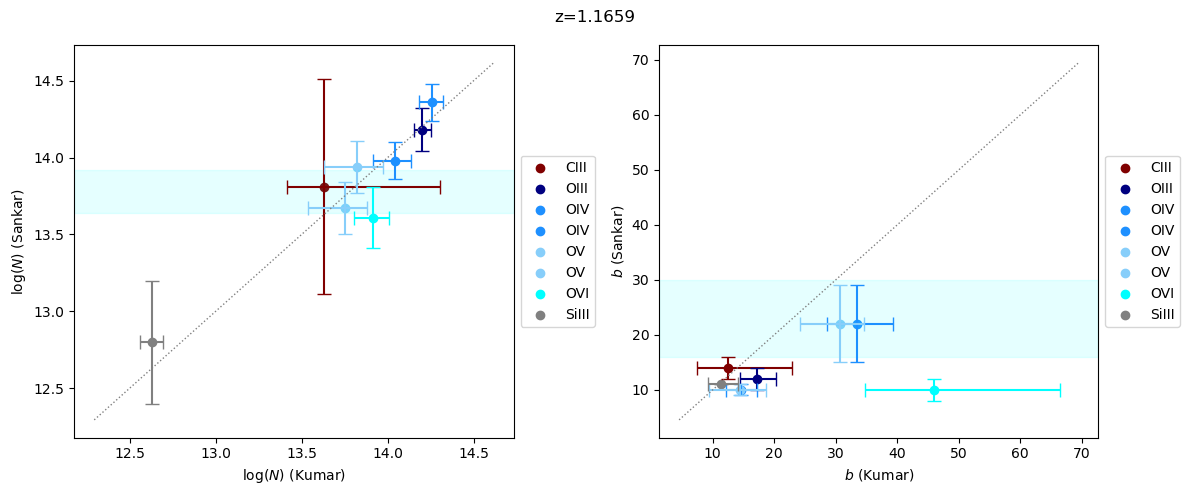

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_comparison_plots(axes, df4.loc[[0,1,2,3,4,5,6,8],:].reset_index())

axes[0].axhspan(float(df4.loc[7,['logN_lo_ss']]), float(df4.loc[7,['logN_hi_ss']]), color=color_dict['OVI'], alpha=0.1)
axes[1].axhspan(float(df4.loc[7,['b_lo_ss']]), float(df4.loc[7,['b_hi_ss']]), color=color_dict['OVI'], alpha=0.1)

fig.suptitle('z=1.1659')
plt.tight_layout()

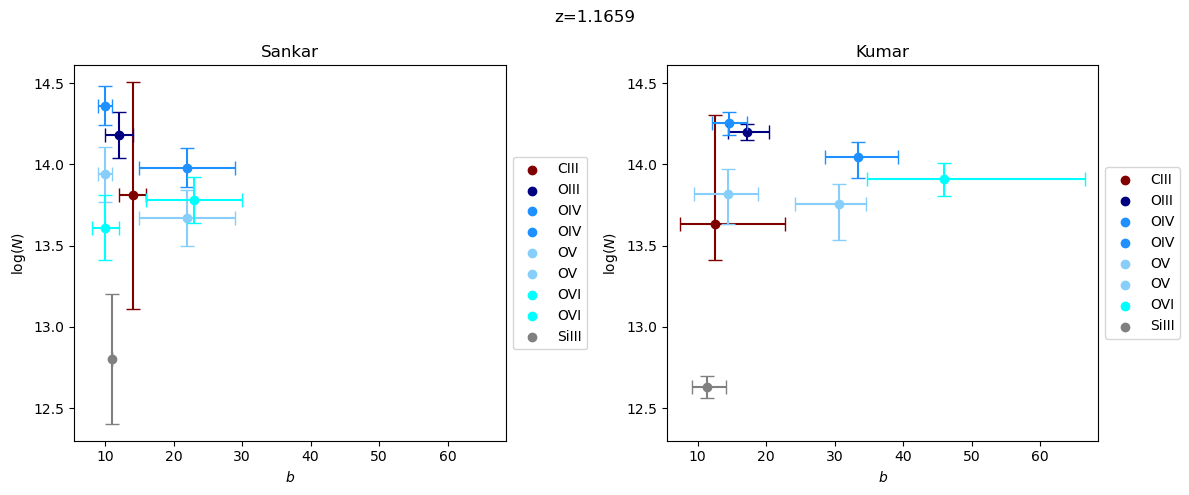

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_phase_plot(axes[0], df4, 'ss', 'Sankar')
make_phase_plot(axes[1], df4.loc[[0,1,2,3,4,5,6,8],:].reset_index(), 'sk', 'Kumar')

axes_dyn_range(axes, df4)

fig.suptitle('z=1.1659')
plt.tight_layout()

# z=1.2777 absorber

In [56]:
df5

,Line,logN_lo_sk,logN_mid_sk,logN_hi_sk,b_lo_sk,b_mid_sk,b_hi_sk,v_lo_sk,v_mid_sk,v_hi_sk,...,W_r_hi_ss,logN_lo_ss,logN_mid_ss,logN_hi_ss,b_lo_ss,b_mid_ss,b_hi_ss,v_lo_ss,v_mid_ss,v_hi_ss
0,CIII,12.683961,12.897531,13.057391,12.746805,22.090401,43.287358,-1.590000,2.100000,5.790000,...,NaN,12.94,13.10,13.26,9.0,10.0,11.0,-13.0,-8.0,-3.0
1,CIII,12.683961,12.897531,13.057391,12.746805,22.090401,43.287358,-1.590000,2.100000,5.790000,...,NaN,12.63,12.84,13.05,8.0,10.0,12.0,32.0,40.0,48.0
2,NIV,12.870099,12.994893,13.102224,7.648519,11.847406,18.153025,0.610000,2.800000,4.990000,...,NaN,12.91,13.01,13.11,8.0,9.0,10.0,-4.0,-2.0,0.0
3,NIV,12.870099,12.994893,13.102224,7.648519,11.847406,18.153025,0.610000,2.800000,4.990000,...,NaN,12.26,12.49,12.72,7.0,9.0,11.0,31.0,38.0,45.0
4,OIII,13.746020,13.829856,13.903666,14.302806,21.645976,29.316104,-0.476971,3.542213,8.471803,...,NaN,13.55,13.66,13.77,8.0,9.0,10.0,-9.0,-5.0,-1.0
5,OIII,13.746020,13.829856,13.903666,14.302806,21.645976,29.316104,-0.476971,3.542213,8.471803,...,NaN,13.03,13.25,13.47,7.0,9.0,11.0,25.0,32.0,39.0
6,OIV,14.367718,14.413017,14.464200,9.957140,10.836791,11.800283,-1.228431,-0.527861,0.177870,...,NaN,14.37,14.44,14.51,8.0,9.0,10.0,0.0,1.0,2.0
7,OIV,14.367718,14.413017,14.464200,9.957140,10.836791,11.800283,-1.228431,-0.527861,0.177870,...,NaN,14.16,14.23,14.30,6.0,8.0,10.0,38.0,39.0,40.0
8,OIV,14.153111,14.194236,14.240401,9.301628,10.560989,12.067405,35.749310,36.640368,37.504106,...,NaN,14.37,14.44,14.51,8.0,9.0,10.0,0.0,1.0,2.0
9,OIV,14.153111,14.194236,14.240401,9.301628,10.560989,12.067405,35.749310,36.640368,37.504106,...,NaN,14.16,14.23,14.30,6.0,8.0,10.0,38.0,39.0,40.0


In [57]:
df5 = df5.drop(index=[7,8,11,12,15,16,19,20,23,24])
df5 = df5.reset_index(drop=True)

In [58]:
df5

,Line,logN_lo_sk,logN_mid_sk,logN_hi_sk,b_lo_sk,b_mid_sk,b_hi_sk,v_lo_sk,v_mid_sk,v_hi_sk,...,W_r_hi_ss,logN_lo_ss,logN_mid_ss,logN_hi_ss,b_lo_ss,b_mid_ss,b_hi_ss,v_lo_ss,v_mid_ss,v_hi_ss
0,CIII,12.683961,12.897531,13.057391,12.746805,22.090401,43.287358,-1.590000,2.100000,5.790000,...,NaN,12.94,13.10,13.26,9.0,10.0,11.0,-13.0,-8.0,-3.0
1,CIII,12.683961,12.897531,13.057391,12.746805,22.090401,43.287358,-1.590000,2.100000,5.790000,...,NaN,12.63,12.84,13.05,8.0,10.0,12.0,32.0,40.0,48.0
2,NIV,12.870099,12.994893,13.102224,7.648519,11.847406,18.153025,0.610000,2.800000,4.990000,...,NaN,12.91,13.01,13.11,8.0,9.0,10.0,-4.0,-2.0,0.0
3,NIV,12.870099,12.994893,13.102224,7.648519,11.847406,18.153025,0.610000,2.800000,4.990000,...,NaN,12.26,12.49,12.72,7.0,9.0,11.0,31.0,38.0,45.0
4,OIII,13.746020,13.829856,13.903666,14.302806,21.645976,29.316104,-0.476971,3.542213,8.471803,...,NaN,13.55,13.66,13.77,8.0,9.0,10.0,-9.0,-5.0,-1.0
5,OIII,13.746020,13.829856,13.903666,14.302806,21.645976,29.316104,-0.476971,3.542213,8.471803,...,NaN,13.03,13.25,13.47,7.0,9.0,11.0,25.0,32.0,39.0
6,OIV,14.367718,14.413017,14.464200,9.957140,10.836791,11.800283,-1.228431,-0.527861,0.177870,...,NaN,14.37,14.44,14.51,8.0,9.0,10.0,0.0,1.0,2.0
7,OIV,14.153111,14.194236,14.240401,9.301628,10.560989,12.067405,35.749310,36.640368,37.504106,...,NaN,14.16,14.23,14.30,6.0,8.0,10.0,38.0,39.0,40.0
8,OV,14.144809,14.347302,14.786749,10.671846,15.246900,20.727083,-7.325579,-1.656498,3.743214,...,NaN,14.39,14.69,14.99,10.0,12.0,14.0,-1.0,0.0,1.0
9,OV,13.890393,14.173814,14.613757,8.053094,12.727329,18.792482,26.542005,32.498146,38.146602,...,NaN,13.84,14.03,14.22,8.0,10.0,12.0,39.0,40.0,41.0


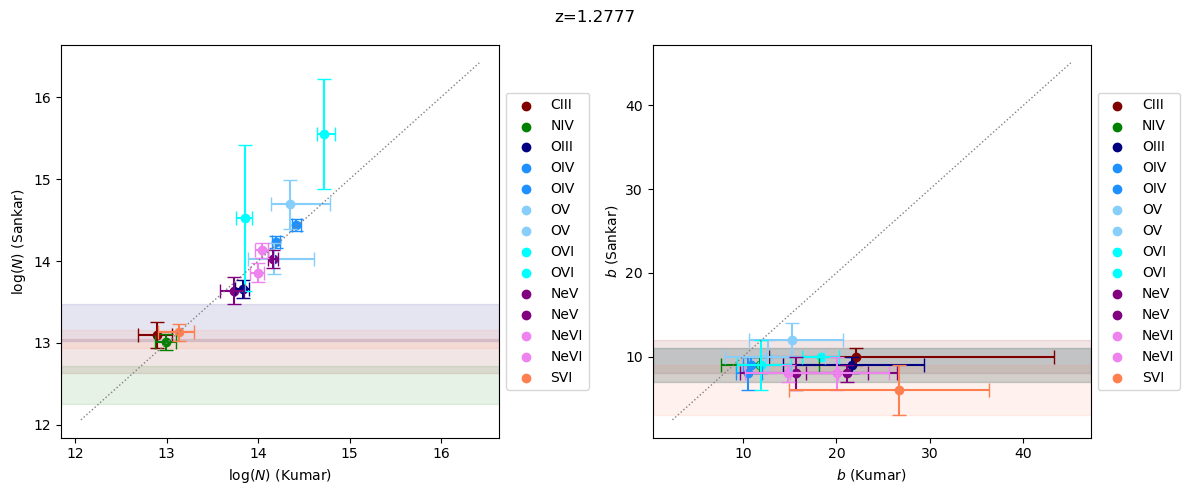

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))


axes[0].axhspan(float(df5.loc[1,['logN_lo_ss']]), float(df5.loc[1,['logN_hi_ss']]), color=color_dict['CIII'], alpha=0.1)
axes[1].axhspan(float(df5.loc[1,['b_lo_ss']]), float(df5.loc[1,['b_hi_ss']]), color=color_dict['CIII'], alpha=0.1)

axes[0].axhspan(float(df5.loc[3,['logN_lo_ss']]), float(df5.loc[3,['logN_hi_ss']]), color=color_dict['NIV'], alpha=0.1)
axes[1].axhspan(float(df5.loc[3,['b_lo_ss']]), float(df5.loc[3,['b_hi_ss']]), color=color_dict['NIV'], alpha=0.1)

axes[0].axhspan(float(df5.loc[5,['logN_lo_ss']]), float(df5.loc[5,['logN_hi_ss']]), color=color_dict['OIII'], alpha=0.1)
axes[1].axhspan(float(df5.loc[5,['b_lo_ss']]), float(df5.loc[5,['b_hi_ss']]), color=color_dict['OIII'], alpha=0.1)

axes[0].axhspan(float(df5.loc[17,['logN_lo_ss']]), float(df5.loc[17,['logN_hi_ss']]), color=color_dict['SVI'], alpha=0.1)
axes[1].axhspan(float(df5.loc[17,['b_lo_ss']]), float(df5.loc[17,['b_hi_ss']]), color=color_dict['SVI'], alpha=0.1)

make_comparison_plots(axes, df5.loc[[0,2,4,6,7,8,9,10,11,12,13,14,15,16],:].reset_index())


fig.suptitle('z=1.2777')
plt.tight_layout()

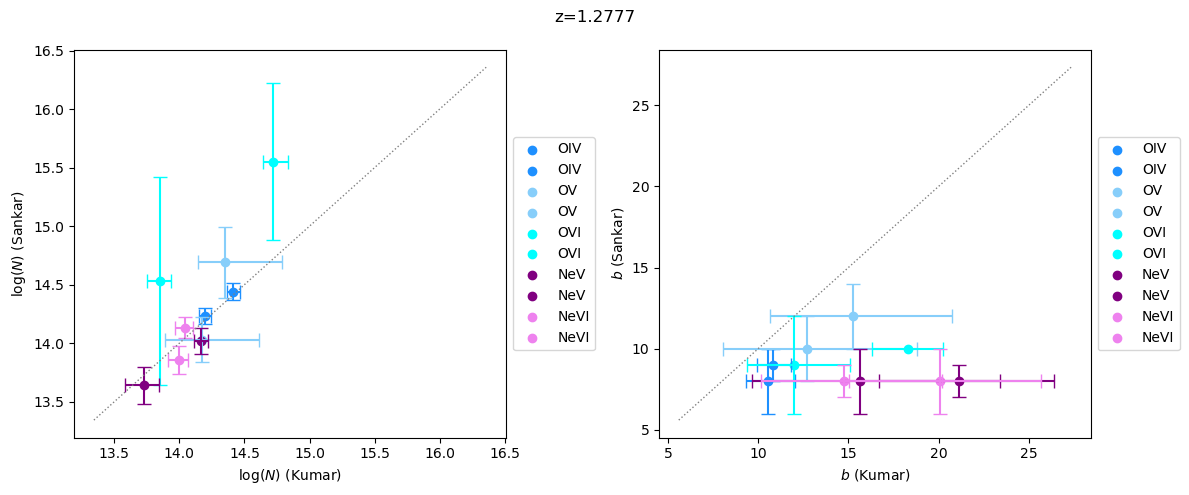

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_comparison_plots(axes, df5.loc[[6,7,8,9,10,11,12,13,14,15],:].reset_index())

fig.suptitle('z=1.2777')
plt.tight_layout()

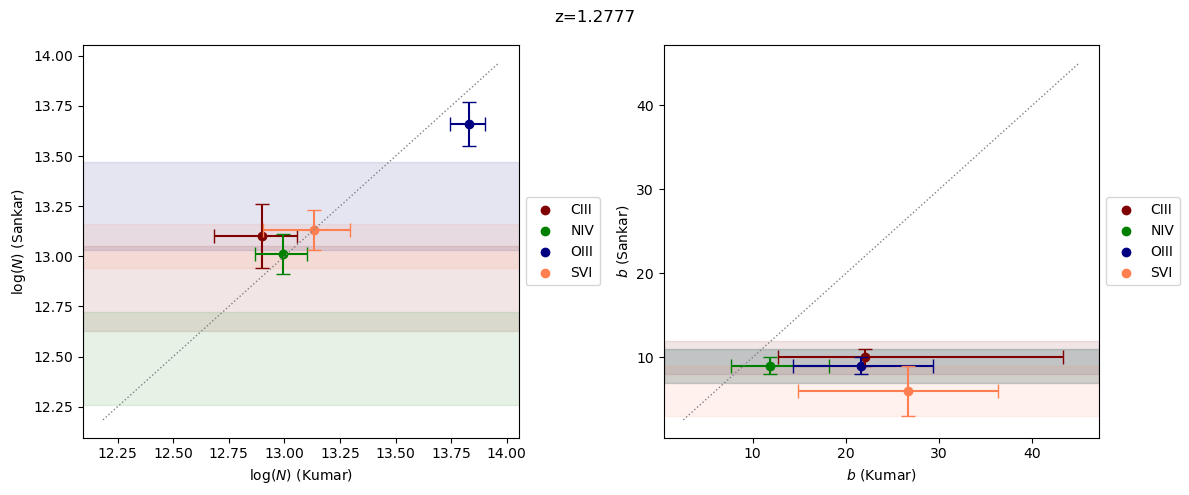

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))


axes[0].axhspan(float(df5.loc[1,['logN_lo_ss']]), float(df5.loc[1,['logN_hi_ss']]), color=color_dict['CIII'], alpha=0.1)
axes[1].axhspan(float(df5.loc[1,['b_lo_ss']]), float(df5.loc[1,['b_hi_ss']]), color=color_dict['CIII'], alpha=0.1)

axes[0].axhspan(float(df5.loc[3,['logN_lo_ss']]), float(df5.loc[3,['logN_hi_ss']]), color=color_dict['NIV'], alpha=0.1)
axes[1].axhspan(float(df5.loc[3,['b_lo_ss']]), float(df5.loc[3,['b_hi_ss']]), color=color_dict['NIV'], alpha=0.1)

axes[0].axhspan(float(df5.loc[5,['logN_lo_ss']]), float(df5.loc[5,['logN_hi_ss']]), color=color_dict['OIII'], alpha=0.1)
axes[1].axhspan(float(df5.loc[5,['b_lo_ss']]), float(df5.loc[5,['b_hi_ss']]), color=color_dict['OIII'], alpha=0.1)

axes[0].axhspan(float(df5.loc[17,['logN_lo_ss']]), float(df5.loc[17,['logN_hi_ss']]), color=color_dict['SVI'], alpha=0.1)
axes[1].axhspan(float(df5.loc[17,['b_lo_ss']]), float(df5.loc[17,['b_hi_ss']]), color=color_dict['SVI'], alpha=0.1)

make_comparison_plots(axes, df5.loc[[0,2,4,16],:].reset_index())


fig.suptitle('z=1.2777')
plt.tight_layout()

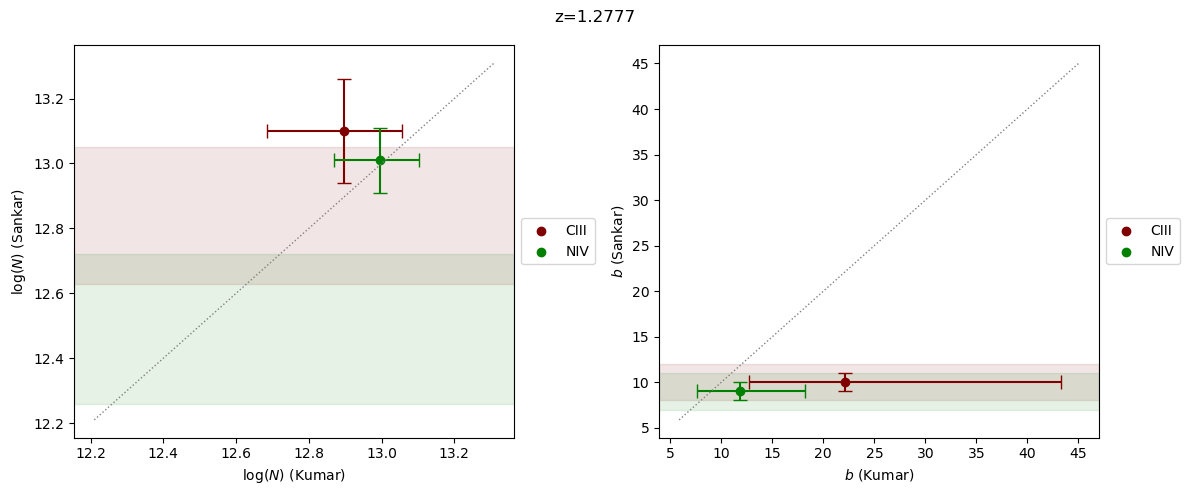

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))


axes[0].axhspan(float(df5.loc[1,['logN_lo_ss']]), float(df5.loc[1,['logN_hi_ss']]), color=color_dict['CIII'], alpha=0.1)
axes[1].axhspan(float(df5.loc[1,['b_lo_ss']]), float(df5.loc[1,['b_hi_ss']]), color=color_dict['CIII'], alpha=0.1)

axes[0].axhspan(float(df5.loc[3,['logN_lo_ss']]), float(df5.loc[3,['logN_hi_ss']]), color=color_dict['NIV'], alpha=0.1)
axes[1].axhspan(float(df5.loc[3,['b_lo_ss']]), float(df5.loc[3,['b_hi_ss']]), color=color_dict['NIV'], alpha=0.1)

make_comparison_plots(axes, df5.loc[[0,2],:].reset_index())


fig.suptitle('z=1.2777')
plt.tight_layout()

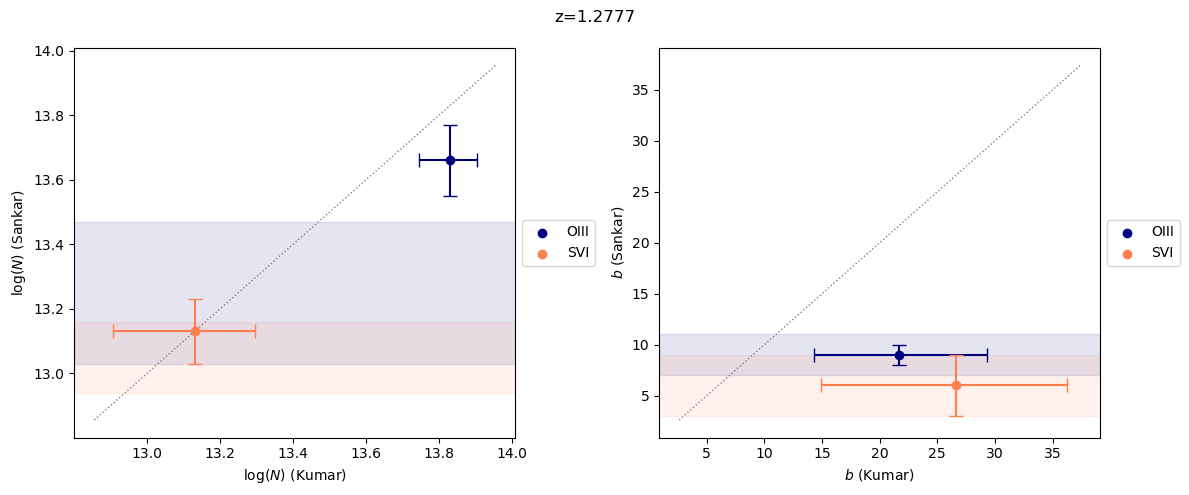

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].axhspan(float(df5.loc[5,['logN_lo_ss']]), float(df5.loc[5,['logN_hi_ss']]), color=color_dict['OIII'], alpha=0.1)
axes[1].axhspan(float(df5.loc[5,['b_lo_ss']]), float(df5.loc[5,['b_hi_ss']]), color=color_dict['OIII'], alpha=0.1)

axes[0].axhspan(float(df5.loc[17,['logN_lo_ss']]), float(df5.loc[17,['logN_hi_ss']]), color=color_dict['SVI'], alpha=0.1)
axes[1].axhspan(float(df5.loc[17,['b_lo_ss']]), float(df5.loc[17,['b_hi_ss']]), color=color_dict['SVI'], alpha=0.1)

make_comparison_plots(axes, df5.loc[[4,16],:].reset_index())

fig.suptitle('z=1.2777')
plt.tight_layout()

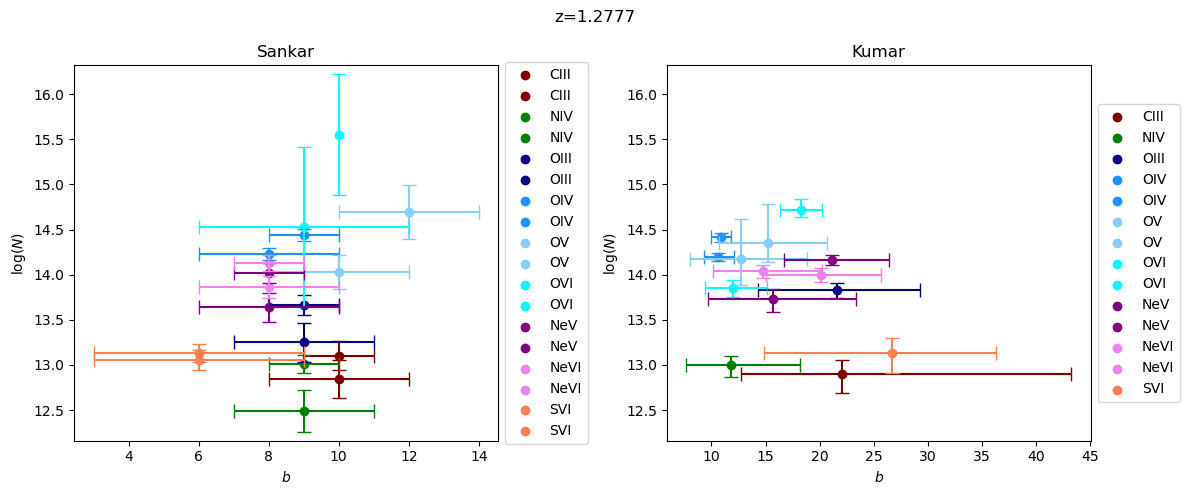

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

make_phase_plot(axes[0], df5, 'ss', 'Sankar')
make_phase_plot(axes[1], df5.loc[[0,2,4,6,7,8,9,10,11,12,13,14,15,16],:].reset_index(), 'sk', 'Kumar')

axes_dyn_range(axes, df5, x_scale=False)

fig.suptitle('z=1.2777')
plt.tight_layout()